In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import numpy as np


In [2]:
class Basic_Autoencoder(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), latent_size=32):
        super().__init__()
        self.input_shape = input_shape
        self.latent_size = latent_size

        # Calculate flattened input size
        self.input_size = input_shape[0] * input_shape[1] * input_shape[2]

        self.encoder = nn.Sequential(
            nn.Linear(self.input_size, 256),
            nn.ReLU(),
            nn.Linear(256, latent_size)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.ReLU(),
            nn.Linear(256, self.input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        out = self.decoder(z)
        return out.view(-1, *self.input_shape)

In [3]:
class Deep_Autoencoder(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), latent_size=32):
        super().__init__()
        self.input_shape = input_shape
        self.latent_size = latent_size

        # Calculate flattened input size
        self.input_size = input_shape[0] * input_shape[1] * input_shape[2]

        self.encoder = nn.Sequential(
            nn.Linear(self.input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_size)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, self.input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        out = self.decoder(z)
        return out.view(-1, *self.input_shape)

In [4]:
class VAE_Encoder(nn.Module):
    def __init__(self, input_size=28 * 28, latent_size=32):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc_mu = nn.Linear(512, latent_size)
        self.fc_logvar = nn.Linear(512, latent_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = self.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


class Sampling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mean, logvar):
        batch_size, dim = mean.shape
        epsilon = torch.randn(batch_size, dim, device=mean.device)
        return mean + torch.exp(0.5 * logvar) * epsilon


class VAE_Decoder(nn.Module):
    def __init__(self, latent_size=32, output_size=28 * 28, output_shape=(1, 28, 28)):
        super().__init__()
        self.output_shape = output_shape
        self.fc1 = nn.Linear(latent_size, 512)
        self.fc2 = nn.Linear(512, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        h = self.relu(self.fc1(z))
        out = self.sigmoid(self.fc2(h))
        return out.view(-1, *self.output_shape)


class BetaVAE(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), latent_size=32):
        super().__init__()
        self.input_shape = input_shape
        self.latent_size = latent_size

        # Calculate flattened input size
        input_size = input_shape[0] * input_shape[1] * input_shape[2]

        self.encoder = VAE_Encoder(input_size=input_size, latent_size=latent_size)
        self.decoder = VAE_Decoder(latent_size=latent_size, output_size=input_size, output_shape=input_shape)
        self.sampling_layer = Sampling()

    def forward(self, x):
        z_mean, z_logvar = self.encoder(x)
        kl_loss = KL_Divergence_Loss(z_mean, z_logvar)
        z_sample = self.sampling_layer(z_mean, z_logvar)
        out = self.decoder(z_sample)
        return kl_loss, out


def KL_Divergence_Loss(z_mean, z_logvar):
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean ** 2 - torch.exp(z_logvar), dim=1)
    kl_loss = kl_loss.mean()
    return kl_loss


class VAELoss(nn.Module):
    def __init__(self, beta=1.0, reduction='sum'):
        super().__init__()
        self.beta = beta
        self.mse = nn.MSELoss(reduction=reduction)
        self.reduction = reduction

    def forward(self, model_output, target):
        kl_loss, reconstruction = model_output
        batch_size = target.size(0)

        recon_loss = self.mse(reconstruction, target)
        recon_loss = recon_loss / batch_size

        total_loss = recon_loss + self.beta * kl_loss

        return total_loss


In [5]:
def train_autoencoder(model,
                      train_loader,
                      val_loader,
                      criterion,
                      optimizer,
                      scheduler=None,
                      device=None,
                      num_epochs=50,
                      threshold=0.1,
                      early_stop_patience=5,
                      output_dir="Models\\Output"):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        # TRAIN
        model.train()
        running_loss = 0.0
        correct_pixels = 0
        total_pixels = 0

        for x, _ in train_loader:
            x = x.to(device)
            batch_size = x.size(0)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, x)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_size

            # Calculate accuracy
            recon = out[1] if isinstance(out, tuple) else out
            pixel_diff = torch.abs(recon - x)
            correct_pixels += (pixel_diff < threshold).sum().item()
            total_pixels += recon.numel()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100.0 * correct_pixels / total_pixels
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # VALIDATION
        model.eval()
        val_running_loss = 0.0
        val_correct_pixels = 0
        val_total_pixels = 0

        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                batch_size = x.size(0)
                out = model(x)
                loss = criterion(out, x)
                val_running_loss += loss.item() * batch_size

                # Calculate accuracy
                recon = out[1] if isinstance(out, tuple) else out
                pixel_diff = torch.abs(recon - x)
                val_correct_pixels += (pixel_diff < threshold).sum().item()
                val_total_pixels += recon.numel()

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc = 100.0 * val_correct_pixels / val_total_pixels
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        tqdm.write(
            f"Epoch {len(train_losses)}/{num_epochs} | "
            f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | "
            f"Train Acc: {epoch_train_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%"
        )

        # Scheduler step
        if scheduler:
            scheduler.step(epoch_val_loss)

        # Early stopping
        loss_diff = np.abs(epoch_val_loss - best_val_loss)
        if early_stop_patience or loss_diff < threshold:
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                patience_counter = 0
                best_state = model.state_dict().copy()
            else:
                patience_counter += 1
                if patience_counter >= early_stop_patience:
                    tqdm.write(f"Early stopping at epoch {len(train_losses)}")
                    if best_state:
                        model.load_state_dict(best_state)
                    break

    metrics = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_accuracy": train_accuracies,
        "val_accuracy": val_accuracies,
    }

    model_path = os.path.join(output_dir, f"{model.__class__.__name__}_ep{len(train_losses)}.pth")
    metrics_path = os.path.join(output_dir, f"{model.__class__.__name__}_ep{len(train_losses)}_metrics.pth")

    torch.save(model.state_dict(), model_path)
    torch.save(metrics, metrics_path)

    tqdm.write(f"Model saved to: {model_path}")

    return metrics

In [6]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics["train_loss"]) + 1)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics["train_loss"], label="train")
    plt.plot(epochs, metrics["val_loss"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss curve")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["train_accuracy"], label="train")
    plt.plot(epochs, metrics["val_accuracy"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Reconstruction Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [7]:
def test_autoencoder(model_base_dir,
                     models,
                     test_loader,
                     model_names=None,
                     show_examples=8,
                     device=None,
                     threshold=0.1):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)

    if not isinstance(models, list):
        models = [models]

    processed_models = []
    extracted_names = []

    for item in models:
        if isinstance(item, tuple):
            if len(item) == 3:
                model, load_path, name = item
                extracted_names.append(name)
            elif len(item) == 2:
                model, load_path = item
                extracted_names.append(None)
            else:
                raise ValueError(f"Invalid tuple format: {item}")
        else:
            model, load_path = item, None
            extracted_names.append(None)

        # only join if load_path is not None
        load_path = os.path.join(model_base_dir, load_path) if load_path is not None else None
        processed_models.append((model, load_path))

    num_models = len(processed_models)

    if model_names is None:
        model_names = []
        for i, name in enumerate(extracted_names):
            if name is not None:
                model_names.append(name)
            else:
                model_names.append(f"Model {i + 1}")

    if len(model_names) < num_models:
        model_names.extend([f"Model {i + 1}" for i in range(len(model_names), num_models)])

    all_metrics = {}
    all_outputs = []
    test_images = None

    def to_display_array(tensor):
        # tensor: (C, H, W) or (H, W) already
        if isinstance(tensor, torch.Tensor):
            arr = tensor.detach().cpu().numpy()
        else:
            arr = np.array(tensor)
        if arr.ndim == 3:
            c, h, w = arr.shape
            if c == 1:
                return arr.squeeze(0)
            else:
                return np.transpose(arr, (1, 2, 0))  # H, W, C
        elif arr.ndim == 2:
            return arr
        else:
            raise ValueError(f"Unsupported image array shape: {arr.shape}")

    for idx, (model, load_path) in enumerate(processed_models):
        model.to(device)

        if load_path is not None:
            state = torch.load(load_path, map_location=device)
            model.load_state_dict(state)

        model.eval()
        correct_pixels = 0
        total_pixels = 0
        first_batch_outputs = None

        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                out = model(x)

                recon = out[1] if isinstance(out, tuple) else out

                pixel_diff = torch.abs(recon - x)
                correct_pixels += (pixel_diff < threshold).sum().item()
                total_pixels += recon.numel()

                if show_examples and first_batch_outputs is None:
                    first_batch_outputs = recon.detach().cpu()
                    if test_images is None:
                        test_images = x.detach().cpu()

        accuracy = 100.0 * correct_pixels / total_pixels if total_pixels > 0 else 0.0

        all_metrics[model_names[idx]] = {
            "test_accuracy": accuracy
        }
        all_outputs.append(first_batch_outputs)

        print(f"{model_names[idx]} - Test Accuracy: {accuracy:.2f}%")

    if show_examples and test_images is not None:
        examples = min(show_examples, test_images.size(0))
        num_cols = num_models + 1

        figsize = (num_cols * 2, examples * 2)

        fig, axes = plt.subplots(examples, num_cols, figsize=figsize)

        if examples == 1:
            axes = axes.reshape(1, -1)

        for row in range(examples):
            orig_arr = to_display_array(test_images[row])
            if orig_arr.ndim == 2:
                axes[row, 0].imshow(orig_arr, cmap="gray")
            else:
                axes[row, 0].imshow(orig_arr)
            axes[row, 0].axis("off")
            if row == 0:
                axes[row, 0].set_title("Original", fontsize=10, fontweight='bold')

            for col in range(num_models):
                recon_batch = all_outputs[col]
                if recon_batch is None:
                    # blank if no recon available
                    axes[row, col + 1].axis("off")
                    continue
                recon_arr = to_display_array(recon_batch[row])
                if recon_arr.ndim == 2:
                    axes[row, col + 1].imshow(recon_arr, cmap="gray")
                else:
                    axes[row, col + 1].imshow(recon_arr)
                axes[row, col + 1].axis("off")
                if row == 0:
                    axes[row, col + 1].set_title(model_names[col], fontsize=10, fontweight='bold')

        plt.tight_layout()
        plt.show()

    return all_metrics

In [8]:
# MNIST (grayscale 28x28 images)
transform = transforms.ToTensor()

dataset = datasets.MNIST(
    root="./Datasets",
    train=True,
    download=True,
    transform=transform
)

test_dataset_MNIST = datasets.MNIST(
    root="./Datasets",
    train=False,
    download=True,
    transform=transform
)

In [9]:
# # FashionMNIST (grayscale 28x28 images)
# transform = transforms.ToTensor()
#
# dataset = datasets.FashionMNIST(
#     root="./Datasets",
#     train=True,
#     download=True,
#     transform=transform
# )

test_dataset_FashionMNIST = datasets.FashionMNIST(
    root="./Datasets",
    train=False,
    download=True,
    transform=transform
)

In [10]:
# CIFAR-10 (RGB 32x32 images)
# transform = transforms.ToTensor()
#
# dataset = datasets.CIFAR10(
#     root="./Datasets",
#     train=True,
#     download=True,
#     transform=transform
# )

test_dataset_CIFAR10 = datasets.CIFAR10(
    root="./Datasets",
    train=False,
    download=True,
    transform=transform
)

In [11]:
# Training variables

batch_size = 256
num_epochs = 50
train_len = int(len(dataset) * 0.9)
val_len = len(dataset) - train_len

device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# # Training the Basic Autoencoder
#
# model = Basic_Autoencoder(input_shape=(3, 32, 32), latent_size=64)
# print("Using device:", device)
# model.to(device)
#
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     patience=3,
#     factor=0.5
# )
#
# metrics = train_autoencoder(
#     model,
#     train_loader,
#     val_loader,
#     criterion,
#     optimizer,
#     scheduler=scheduler,
#     device=device,
#     num_epochs=num_epochs,
#     early_stop_patience=5,
#     output_dir="Models\\CIFAR10"
# )
#
# plot_metrics(metrics)

In [13]:
# # Training the Deep Autoencoder
#
# model = Deep_Autoencoder(input_shape=(3, 32, 32), latent_size=64)
# print("Using device:", device)
# model.to(device)
#
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     patience=3,
#     factor=0.5
# )
#
# metrics = train_autoencoder(
#     model,
#     train_loader,
#     val_loader,
#     criterion,
#     optimizer,
#     scheduler=scheduler,
#     device=device,
#     num_epochs=num_epochs,
#     early_stop_patience=5,
#     output_dir="Models\\CIFAR10"
# )
#
# plot_metrics(metrics)

In [14]:
# # Training the VAE
#
# model = BetaVAE(input_shape=(3, 32, 32), latent_size=64)
# model.to(device)
# criterion = VAELoss(beta=1.0)
# vae_optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     vae_optimizer,
#     mode='min',
#     patience=3,
#     factor=0.5,
# )
#
# vae_metrics = train_autoencoder(
#     model,
#     train_loader,
#     val_loader,
#     criterion,
#     vae_optimizer,
#     scheduler=scheduler,
#     device=device,
#     num_epochs=num_epochs,
#     early_stop_patience=5,
#     output_dir="Models\\CIFAR10"
# )
#
# plot_metrics(vae_metrics)


In [15]:
# # Testing the autoencoder
#
# test_loader = DataLoader(test_dataset_CIFAR10, batch_size=batch_size, shuffle=False)
#
# basic_model = Basic_Autoencoder(input_shape=(3, 32, 32), latent_size=64)
# deep_model = Deep_Autoencoder(input_shape=(3, 32, 32), latent_size=64)
# vae_model = BetaVAE(input_shape=(3, 32, 32), latent_size=64)
#
# # model_base_dir = "Models\\MNIST"
# # model_base_dir = "Models\\FashionMNIST"
# model_base_dir = "Models\\CIFAR10"
#
# models_to_test = [
#     (basic_model, "Basic_Autoencoder_ep50.pth", "Basic AE"),
#     (deep_model, "Deep_Autoencoder_ep50.pth", "Deep AE"),
#     (vae_model, "BetaVAE_ep50.pth", "β-VAE"),
# ]
#
# test_metrics = test_autoencoder(
#     model_base_dir,
#     models_to_test,
#     test_loader,
#     show_examples=8,
#     device=device
# )


In [16]:
def plot_all_metrics(model_base_dir):
    # Check if directory exists
    if not os.path.exists(model_base_dir):
        print(f"Directory not found: {model_base_dir}")
        return

    # Get all files and filter for metric files
    all_files = os.listdir(model_base_dir)
    metric_files = [f for f in all_files if f.endswith("_metrics.pth")]

    if not metric_files:
        print(f"No metric files found in {model_base_dir}")
        return

    # print(f"Found {len(metric_files)} metric file(s):\n")
    print(f"Plotting metrics from directory: {model_base_dir}\n")

    for filename in sorted(metric_files):
        metric_path = os.path.join(model_base_dir, filename)
        model_name = filename.replace("_metrics.pth", "")

        print(f"Plotting metrics for: {model_name}")

        # Load metrics
        metrics = torch.load(metric_path, map_location='cpu')

        # Plot using existing function
        plot_metrics(metrics)

        print("-" * 50)

Plotting metrics from directory: Models\MNIST

Plotting metrics for: Basic_Autoencoder_ep50


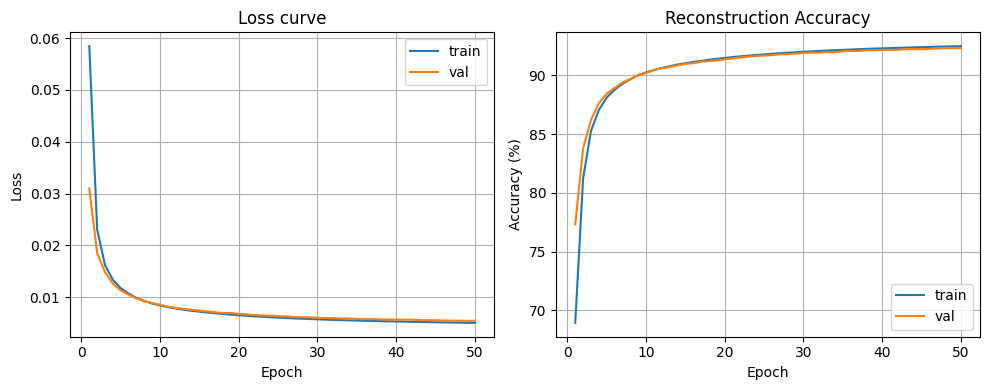

--------------------------------------------------
Plotting metrics for: BetaVAE_ep50


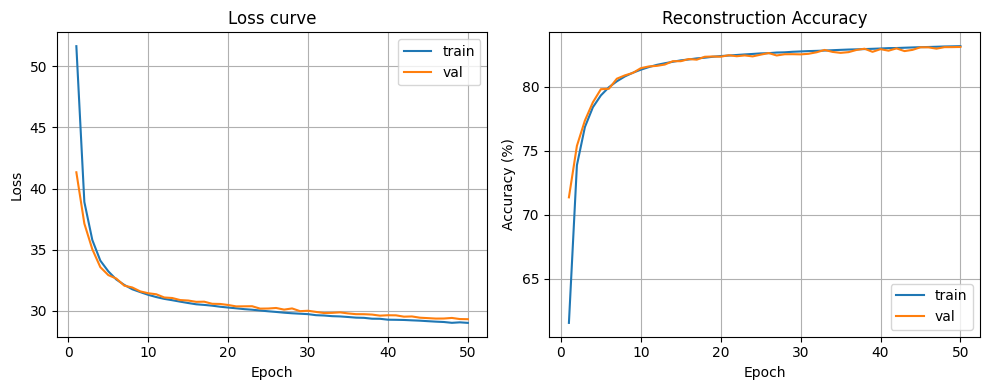

--------------------------------------------------
Plotting metrics for: Deep_Autoencoder_ep50


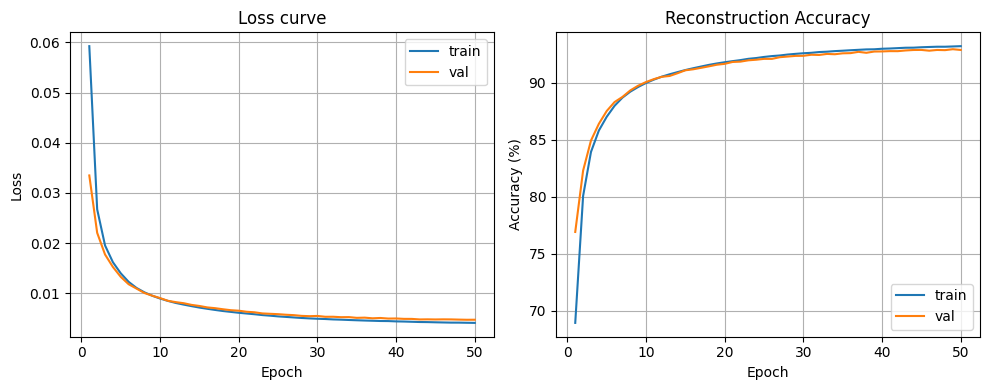

--------------------------------------------------
Plotting metrics from directory: Models\FashionMNIST

Plotting metrics for: Basic_Autoencoder_ep50


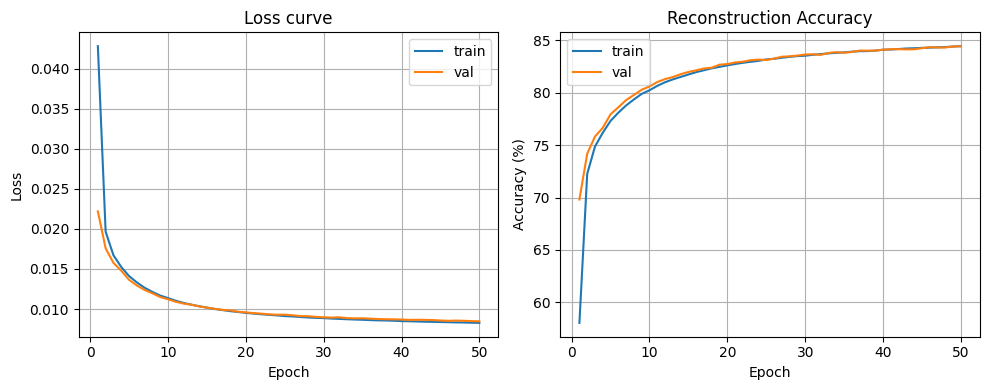

--------------------------------------------------
Plotting metrics for: BetaVAE_ep50


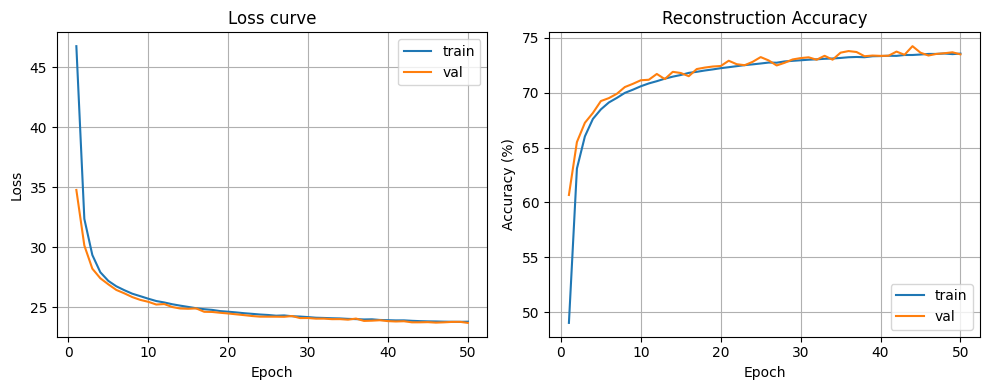

--------------------------------------------------
Plotting metrics for: Deep_Autoencoder_ep50


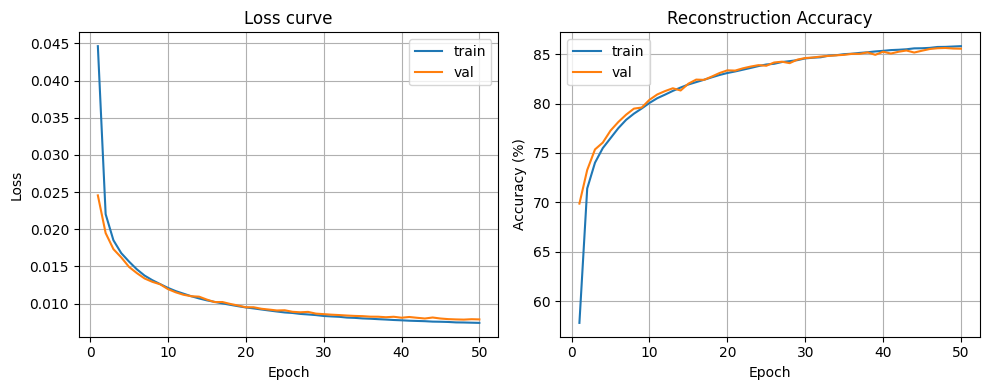

--------------------------------------------------
Plotting metrics from directory: Models\CIFAR10

Plotting metrics for: Basic_Autoencoder_ep50


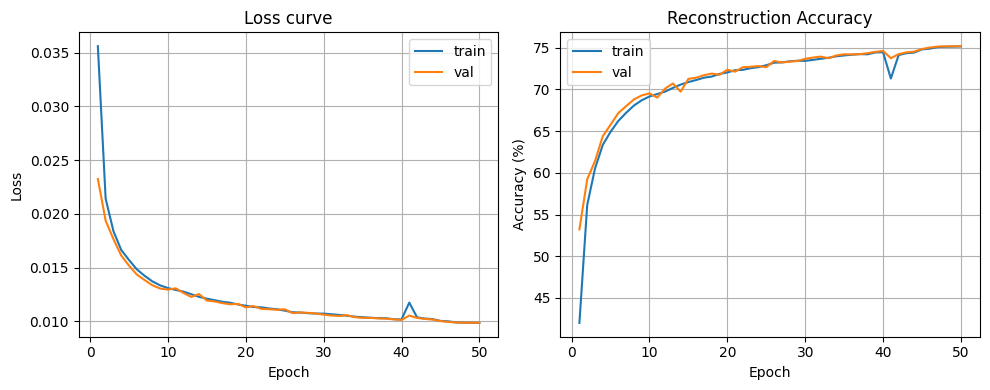

--------------------------------------------------
Plotting metrics for: BetaVAE_ep50


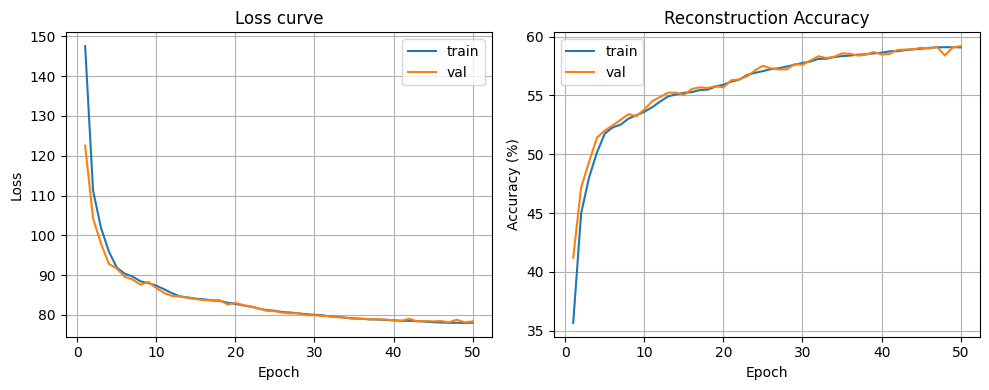

--------------------------------------------------
Plotting metrics for: Deep_Autoencoder_ep50


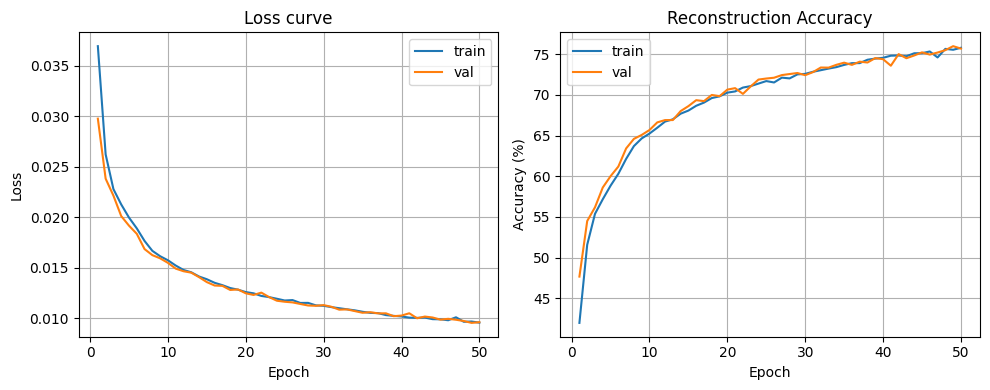

--------------------------------------------------


In [27]:
# plot_all_metrics("Models\\MNIST")
# plot_all_metrics("Models\\FashionMNIST")
# plot_all_metrics("Models\\CIFAR10")

Basic AE - Test Accuracy: 92.53%
Deep AE - Test Accuracy: 93.05%
β-VAE - Test Accuracy: 83.36%


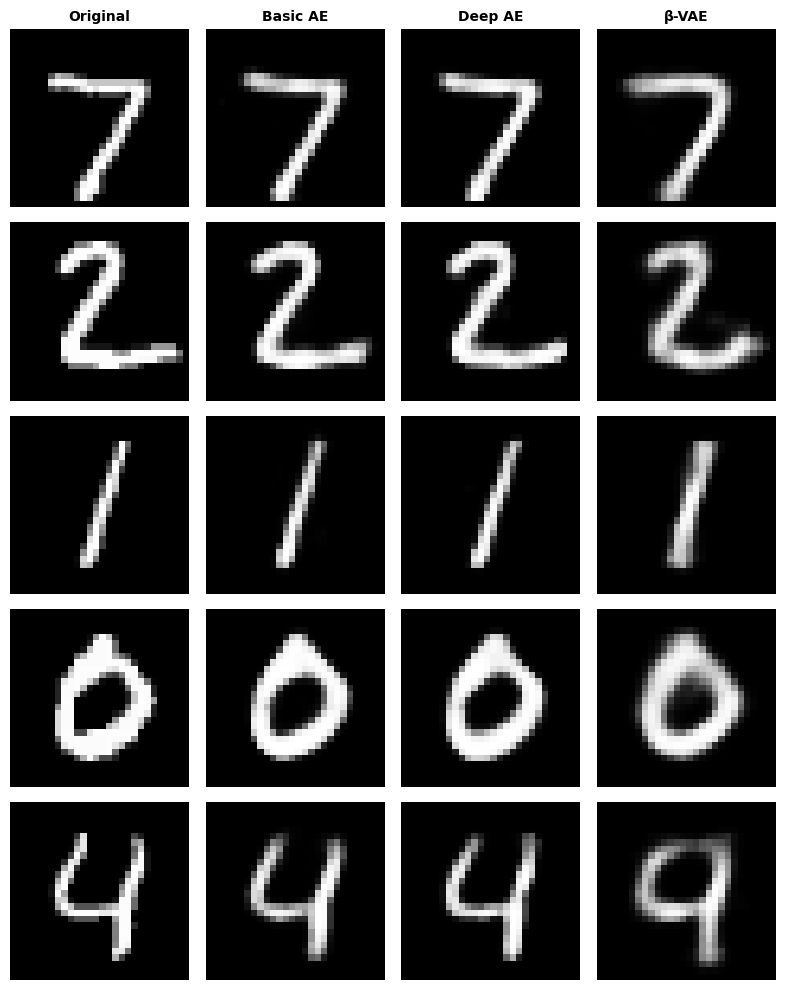

Basic AE - Test Accuracy: 84.16%
Deep AE - Test Accuracy: 85.30%
β-VAE - Test Accuracy: 73.09%


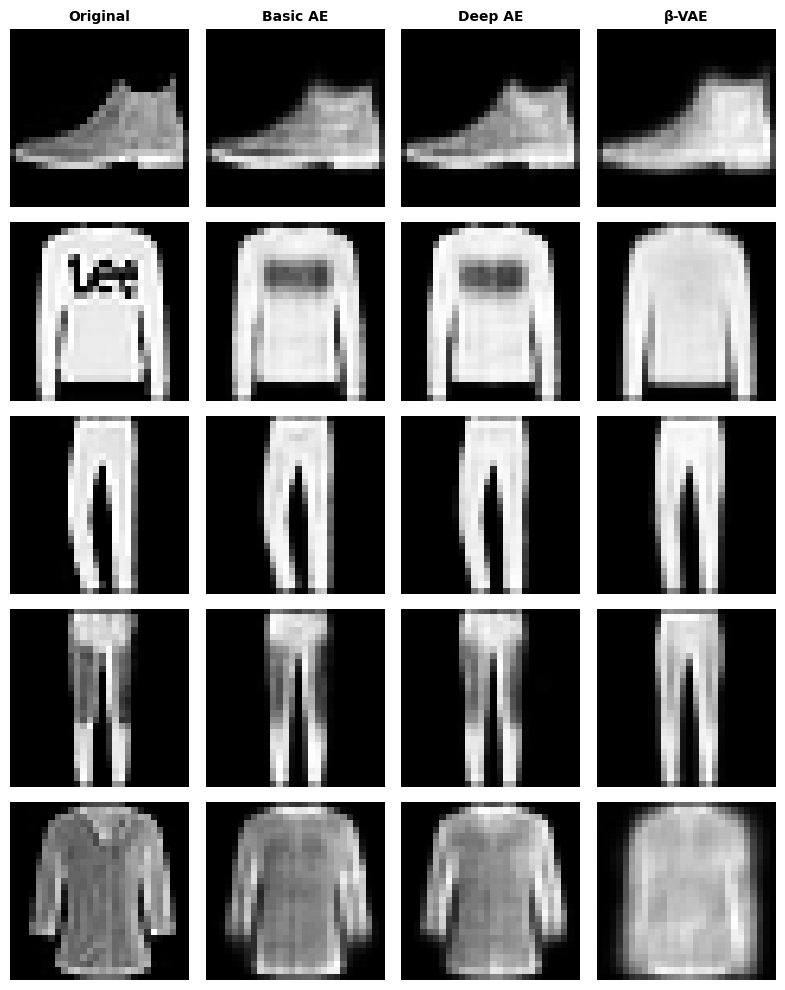

Basic AE - Test Accuracy: 75.13%
Deep AE - Test Accuracy: 75.58%
β-VAE - Test Accuracy: 59.14%


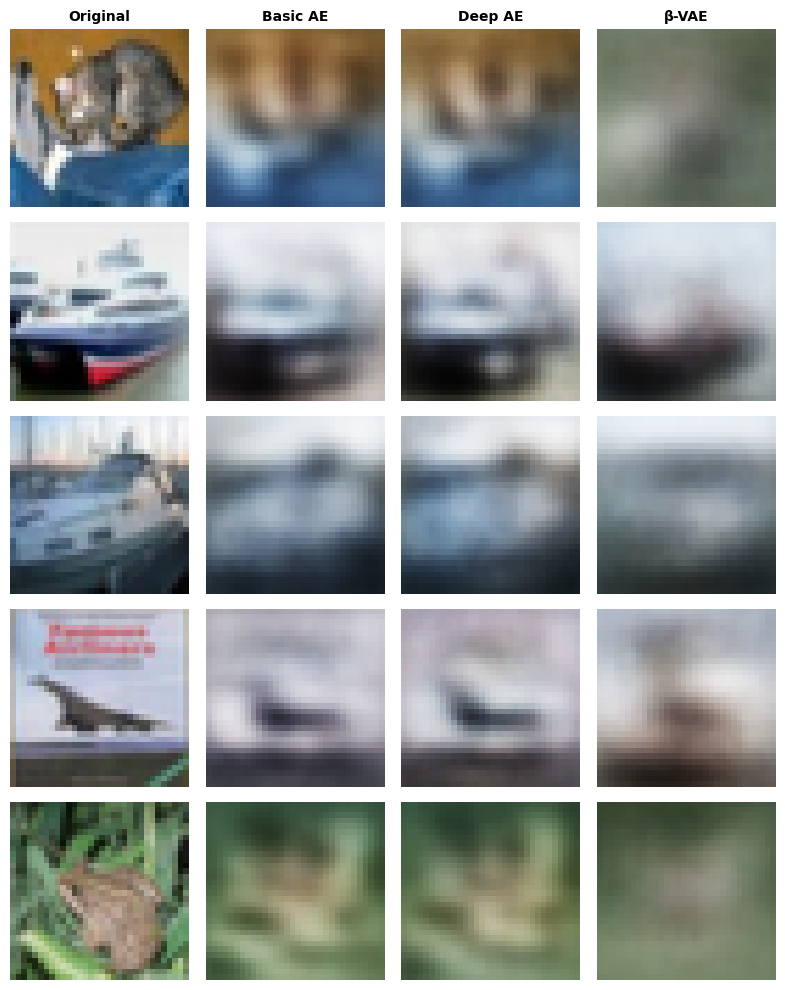

In [26]:
# # Testing the autoencoders
#
# test_metrics = test_autoencoder(
#     "Models\\MNIST",
#     [(Basic_Autoencoder(),
#       "Basic_Autoencoder_ep50.pth", "Basic AE"),
#      (Deep_Autoencoder(),
#       "Deep_Autoencoder_ep50.pth", "Deep AE"),
#      (BetaVAE(),
#       "BetaVAE_ep50.pth", "β-VAE"), ],
#     DataLoader(test_dataset_MNIST, batch_size=batch_size, shuffle=False),
#     show_examples=5,
#     device=device
# )
#
# test_metrics = test_autoencoder(
#     "Models\\FashionMNIST",
#     [(Basic_Autoencoder(),
#       "Basic_Autoencoder_ep50.pth", "Basic AE"),
#      (Deep_Autoencoder(),
#       "Deep_Autoencoder_ep50.pth", "Deep AE"),
#      (BetaVAE(),
#       "BetaVAE_ep50.pth", "β-VAE"), ],
#     DataLoader(test_dataset_FashionMNIST, batch_size=batch_size, shuffle=False),
#     show_examples=5,
#     device=device
# )
#
# test_metrics = test_autoencoder(
#     "Models\\CIFAR10",
#     [(Basic_Autoencoder(input_shape=(3, 32, 32), latent_size=64),
#       "Basic_Autoencoder_ep50.pth", "Basic AE"),
#      (Deep_Autoencoder(input_shape=(3, 32, 32), latent_size=64),
#       "Deep_Autoencoder_ep50.pth", "Deep AE"),
#      (BetaVAE(input_shape=(3, 32, 32), latent_size=64),
#       "BetaVAE_ep50.pth", "β-VAE"), ],
#     DataLoader(test_dataset_CIFAR10, batch_size=batch_size, shuffle=False),
#     show_examples=5,
#     device=device
# )


In [19]:
def train_multiple_beta_vae(
        datasets_config,
        beta_values=[0.0, 0.5, 1.0, 2.0, 5.0],
        batch_size=256,
        num_epochs=50,
        device=None,
        root_dir="Models\\BetaVAE"
):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    print(f"Using device: {device}")
    print(f"Training β-VAE with beta values: {beta_values}")
    print(f"Datasets: {[cfg['name'] for cfg in datasets_config]}\n")

    all_results = {}

    for dataset_cfg in datasets_config:
        dataset = dataset_cfg['dataset']
        dataset_name = dataset_cfg['name']
        input_shape = dataset_cfg['input_shape']
        latent_size = dataset_cfg['latent_size']

        print(f"\n{'=' * 60}")
        print(f"Dataset: {dataset_name} (latent_size={latent_size})")
        print(f"{'=' * 60}\n")

        # Split dataset
        train_len = int(len(dataset) * 0.9)
        val_len = len(dataset) - train_len
        train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        dataset_results = {}

        for beta in beta_values:
            config_name = f"beta_{beta}"

            print(f"\n{'-' * 50}")
            print(f"Training β-VAE with β={beta} on {dataset_name}")
            print(f"{'-' * 50}\n")

            # Create model
            model = BetaVAE(input_shape=input_shape, latent_size=latent_size)
            model.to(device)

            # Create criterion with current beta value
            criterion = VAELoss(beta=beta)
            optimizer = optim.Adam(model.parameters(), lr=1e-3)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='min',
                patience=3,
                factor=0.5
            )

            # Create output directory: Models/BetaVAE/[Dataset]/[config]
            output_dir = os.path.join(root_dir, dataset_name, config_name)
            os.makedirs(output_dir, exist_ok=True)

            # Train model
            metrics = train_autoencoder(
                model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                scheduler=scheduler,
                device=device,
                num_epochs=num_epochs,
                early_stop_patience=5,
                output_dir=output_dir
            )

            # Plot metrics
            print(f"\nPlotting metrics for β={beta}")
            plot_metrics(metrics)

            # Store results
            dataset_results[config_name] = {
                "metrics": metrics,
                "model_path": os.path.join(output_dir, f"BetaVAE_ep{len(metrics['train_loss'])}.pth"),
                "beta": beta,
                "latent_size": latent_size,
                "final_train_loss": metrics['train_loss'][-1],
                "final_val_loss": metrics['val_loss'][-1],
                "final_train_acc": metrics['train_accuracy'][-1],
                "final_val_acc": metrics['val_accuracy'][-1]
            }

        all_results[dataset_name] = dataset_results

        # Print summary for this dataset
        print(f"\n{'=' * 60}")
        print(f"Summary for {dataset_name}")
        print(f"{'=' * 60}")
        for config_name, results in dataset_results.items():
            print(f"\n{config_name}:")
            print(f"  Final Val Loss: {results['final_val_loss']:.4f}")
            print(f"  Final Val Acc: {results['final_val_acc']:.2f}%")

    return all_results

In [21]:
# Prepare datasets configuration with latent sizes
datasets_config = [
    {
        'dataset': datasets.MNIST(root="./Datasets", train=True, download=True, transform=transforms.ToTensor()),
        'name': 'MNIST',
        'input_shape': (1, 28, 28),
        'latent_size': 32
    },
    {
        'dataset': datasets.FashionMNIST(root="./Datasets", train=True, download=True, transform=transforms.ToTensor()),
        'name': 'FashionMNIST',
        'input_shape': (1, 28, 28),
        'latent_size': 32
    },
    {
        'dataset': datasets.CIFAR10(root="./Datasets", train=True, download=True, transform=transforms.ToTensor()),
        'name': 'CIFAR10',
        'input_shape': (3, 32, 32),
        'latent_size': 64
    }
]

# Train with different beta values
beta_values = [0.0, 0.5, 1.0, 2.0, 5.0]

# all_results = train_multiple_beta_vae(
#     datasets_config=datasets_config,
#     beta_values=beta_values,
#     batch_size=256,
#     num_epochs=50,
#     device=device,
#     root_dir="Models\\BetaVAE",
# )

In [23]:
import re

def test_all_models(test_datasets, batch_size, device, models_root="Models\\BetaVAE"):
    test_results = {}

    # Define model configurations for each dataset
    dataset_configs = {
        'MNIST': {'input_shape': (1, 28, 28), 'latent_size': 32},
        'FashionMNIST': {'input_shape': (1, 28, 28), 'latent_size': 32},
        'CIFAR10': {'input_shape': (3, 32, 32), 'latent_size': 64}
    }

    for dataset_name, test_dataset in test_datasets.items():
        if dataset_name not in dataset_configs:
            print(f"Skipping {dataset_name}: no configuration found")
            continue

        config = dataset_configs[dataset_name]
        model_dir = os.path.join(models_root, dataset_name)

        if not os.path.exists(model_dir):
            print(f"Skipping {dataset_name}: directory not found")
            continue

        print(f"\nTesting all β-VAE models for {dataset_name}")

        # Collect all BetaVAE model files from subdirectories
        model_list = []

        # Get all beta subdirectories (e.g., beta_0.0, beta_0.5, etc.)
        beta_dirs = [d for d in os.listdir(model_dir)
                     if os.path.isdir(os.path.join(model_dir, d)) and d.startswith('beta_')]

        for beta_dir in sorted(beta_dirs):
            # Extract beta value from directory name
            beta_match = re.search(r'beta_([\d.]+)', beta_dir)
            if not beta_match:
                continue

            beta = float(beta_match.group(1))
            beta_path = os.path.join(model_dir, beta_dir)

            # Find model file (not the metrics file)
            files_in_beta_dir = os.listdir(beta_path)
            model_files = [f for f in files_in_beta_dir
                          if f.endswith('.pth') and '_metrics' not in f]

            if not model_files:
                print(f"No model file found in {beta_path}")
                continue

            model_file = model_files[0]  # Should only be one model file

            model = BetaVAE(**config)
            display_name = f"β-VAE (β={beta})"

            # Create relative path for test_autoencoder (beta_dir/model_file)
            relative_path = os.path.join(beta_dir, model_file)
            model_list.append((model, relative_path, display_name))

        if not model_list:
            print(f"No β-VAE models found for {dataset_name}")
            continue

        # Test all models for this dataset
        results = test_autoencoder(
            model_dir,
            model_list,
            DataLoader(test_dataset, batch_size=batch_size, shuffle=False),
            show_examples=5,
            device=device
        )

        test_results[dataset_name] = results

    return test_results



Testing all β-VAE models for MNIST
β-VAE (β=0.0) - Test Accuracy: 93.19%
β-VAE (β=0.5) - Test Accuracy: 86.79%
β-VAE (β=1.0) - Test Accuracy: 83.36%
β-VAE (β=2.0) - Test Accuracy: 78.47%
β-VAE (β=5.0) - Test Accuracy: 69.50%


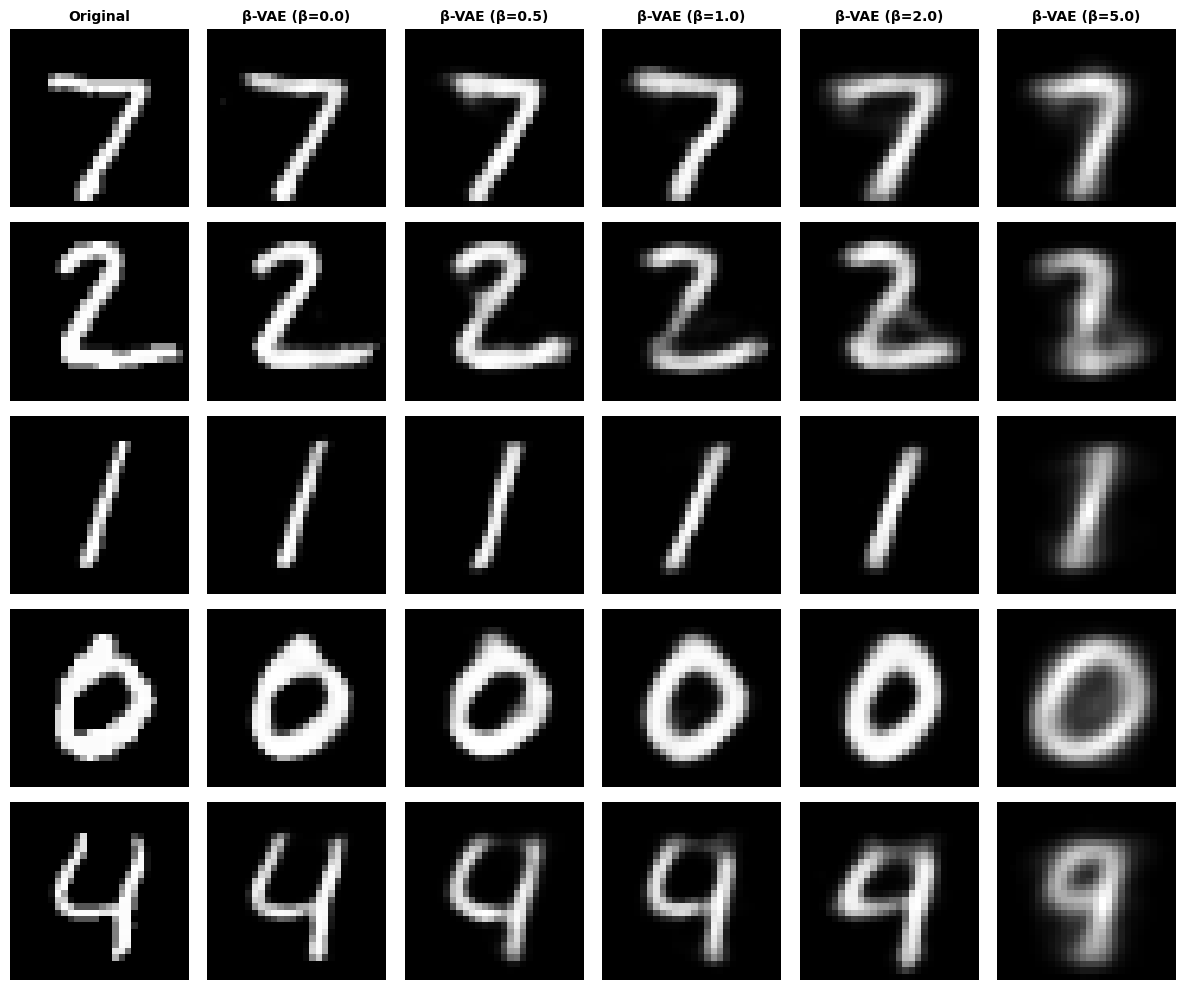


Testing all β-VAE models for FashionMNIST
β-VAE (β=0.0) - Test Accuracy: 85.47%
β-VAE (β=0.5) - Test Accuracy: 76.53%
β-VAE (β=1.0) - Test Accuracy: 73.26%
β-VAE (β=2.0) - Test Accuracy: 69.15%
β-VAE (β=5.0) - Test Accuracy: 62.23%


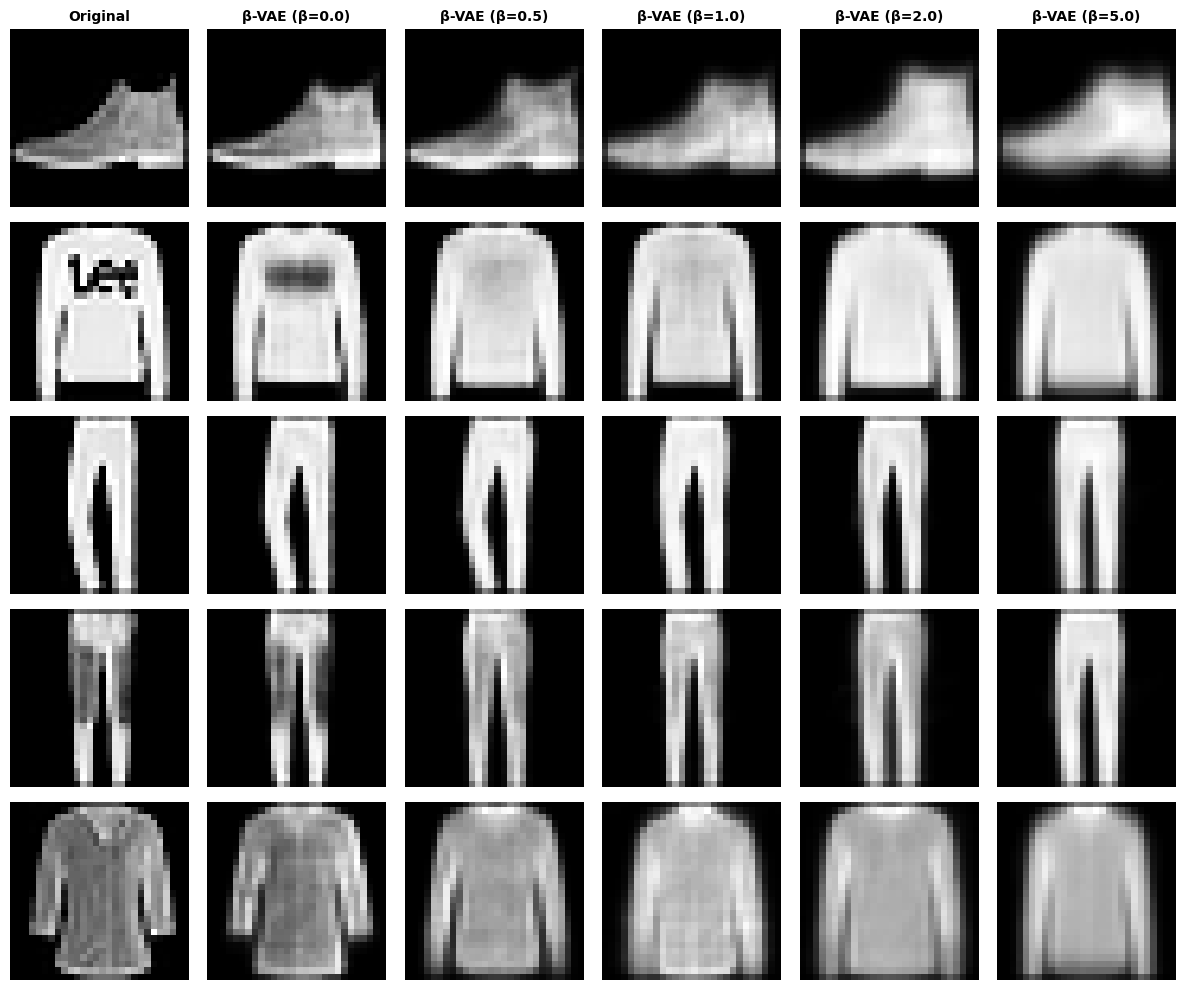


Testing all β-VAE models for CIFAR10
β-VAE (β=0.0) - Test Accuracy: 78.41%
β-VAE (β=0.5) - Test Accuracy: 65.15%
β-VAE (β=1.0) - Test Accuracy: 59.45%
β-VAE (β=2.0) - Test Accuracy: 52.74%
β-VAE (β=5.0) - Test Accuracy: 40.06%


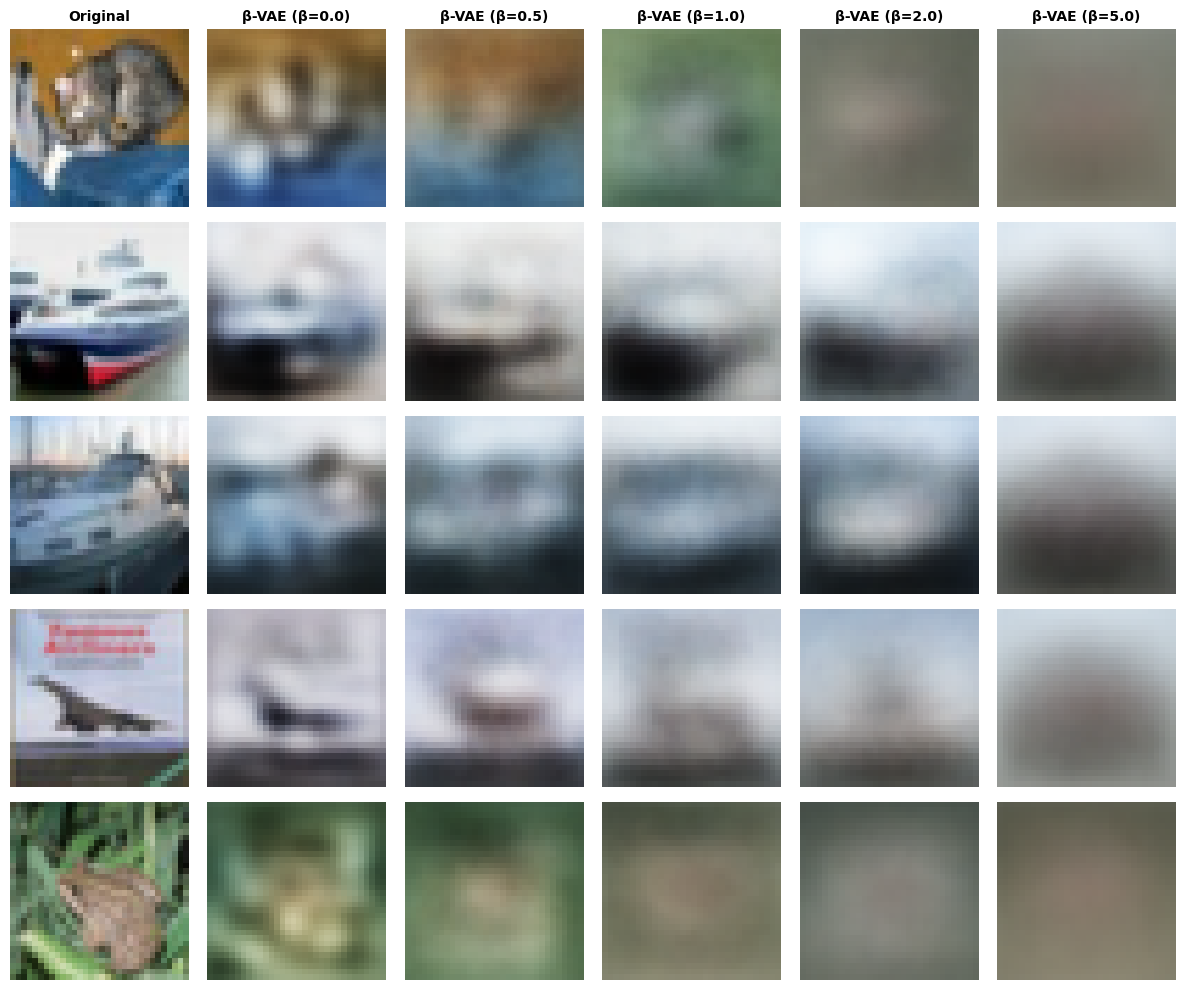

In [25]:
# Define your test datasets
test_datasets = {
    'MNIST': test_dataset_MNIST,
    'FashionMNIST': test_dataset_FashionMNIST,
    'CIFAR10': test_dataset_CIFAR10
}

# Run the test function
all_test_results = test_all_models(
    test_datasets=test_datasets,
    batch_size=32,
    device=device,
    models_root="Models\\BetaVAE"
)

In [28]:
def plot_all_betavae_metrics(models_root="Models\\BetaVAE"):
    if not os.path.exists(models_root):
        print(f"Directory not found: {models_root}")
        return

    # Iterate through dataset directories
    for dataset_name in sorted(os.listdir(models_root)):
        dataset_path = os.path.join(models_root, dataset_name)
        if not os.path.isdir(dataset_path):
            continue

        print(f"\n{'=' * 60}")
        print(f"Dataset: {dataset_name}")
        print(f"{'=' * 60}\n")

        # Iterate through beta directories
        beta_dirs = [d for d in os.listdir(dataset_path)
                     if os.path.isdir(os.path.join(dataset_path, d)) and d.startswith('beta_')]

        for beta_dir in sorted(beta_dirs):
            beta_path = os.path.join(dataset_path, beta_dir)

            # Extract beta value
            beta_match = re.search(r'beta_([\d.]+)', beta_dir)
            if not beta_match:
                continue
            beta = float(beta_match.group(1))

            # Find metrics file
            metric_files = [f for f in os.listdir(beta_path) if f.endswith("_metrics.pth")]
            if not metric_files:
                continue

            metrics_path = os.path.join(beta_path, metric_files[0])

            print(f"β = {beta}")

            # Load and plot metrics
            metrics = torch.load(metrics_path, map_location='cpu')
            plot_metrics(metrics)

            print("-" * 50)


Dataset: CIFAR10

β = 0.0


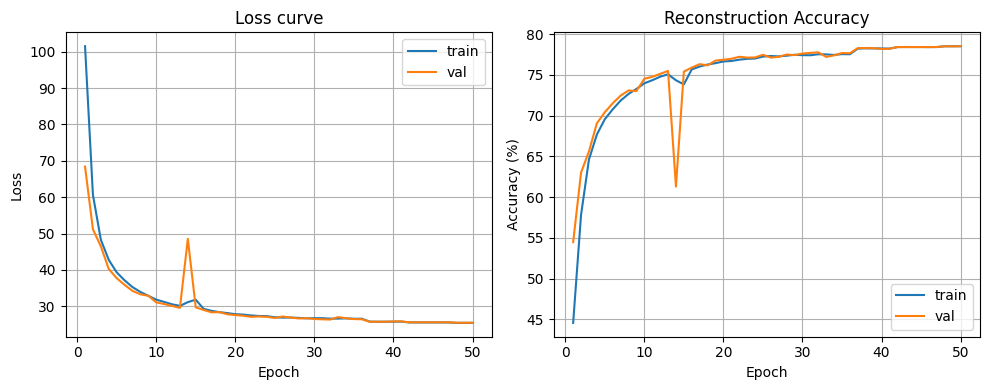

--------------------------------------------------
β = 0.5


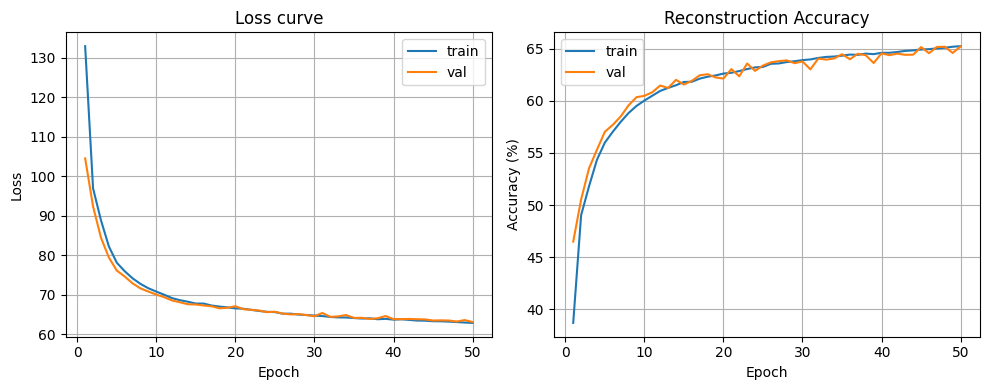

--------------------------------------------------
β = 1.0


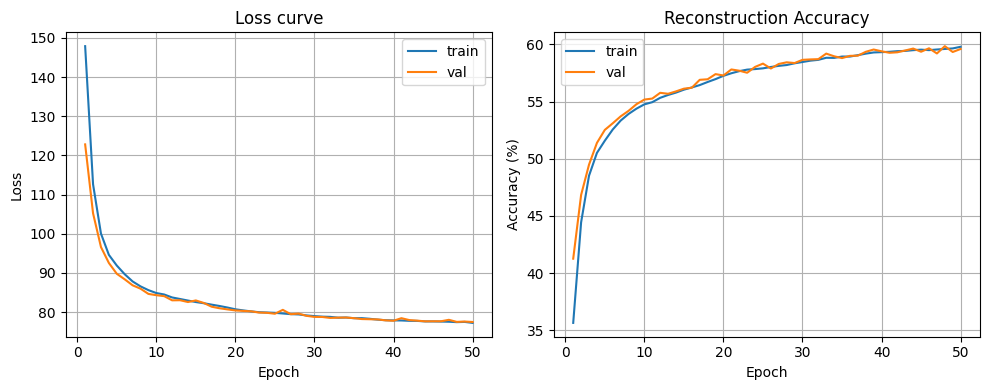

--------------------------------------------------
β = 2.0


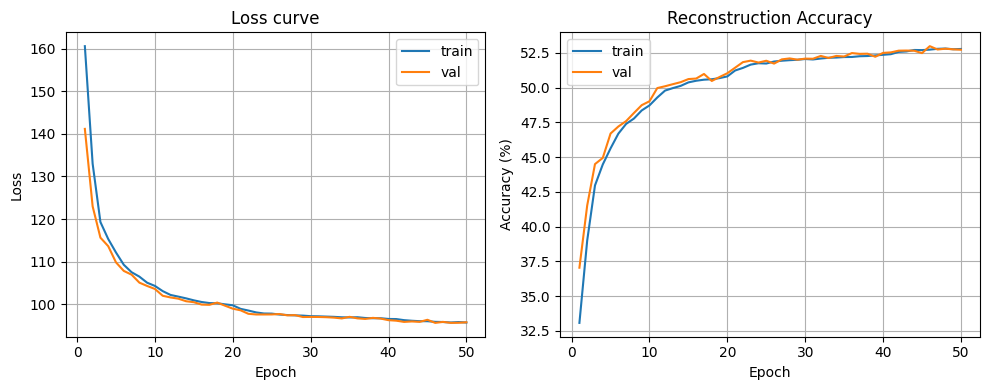

--------------------------------------------------
β = 5.0


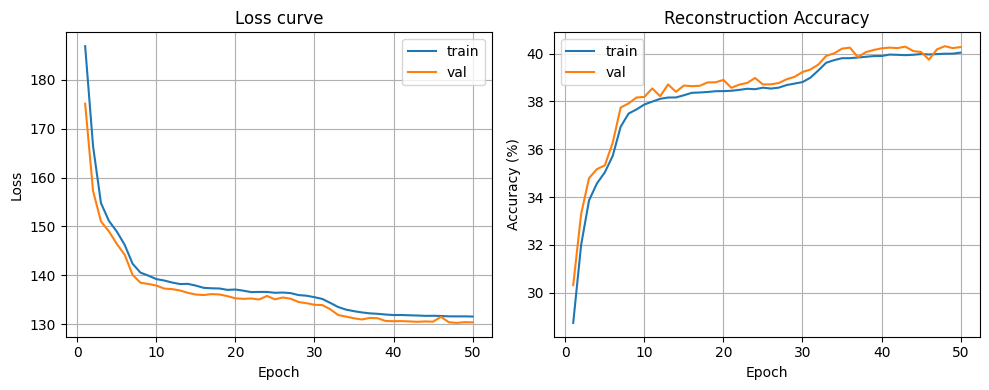

--------------------------------------------------

Dataset: FashionMNIST

β = 0.0


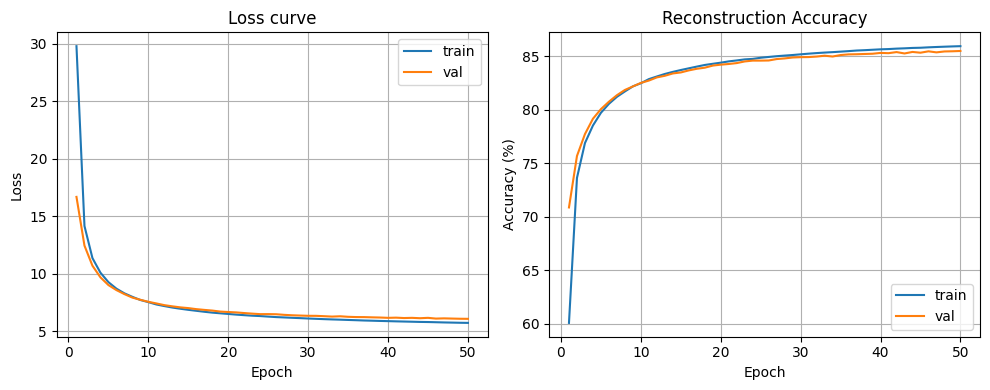

--------------------------------------------------
β = 0.5


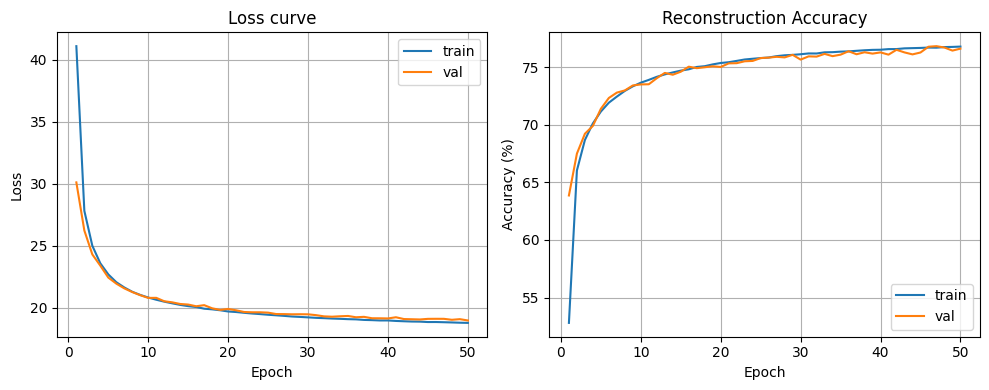

--------------------------------------------------
β = 1.0


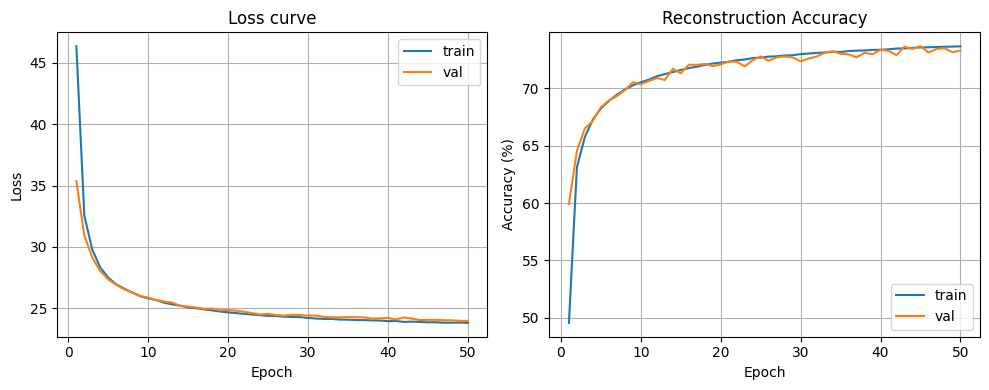

--------------------------------------------------
β = 2.0


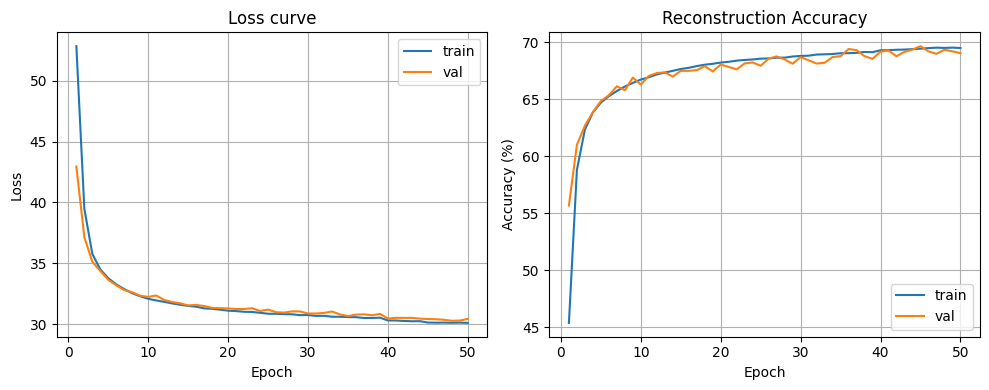

--------------------------------------------------
β = 5.0


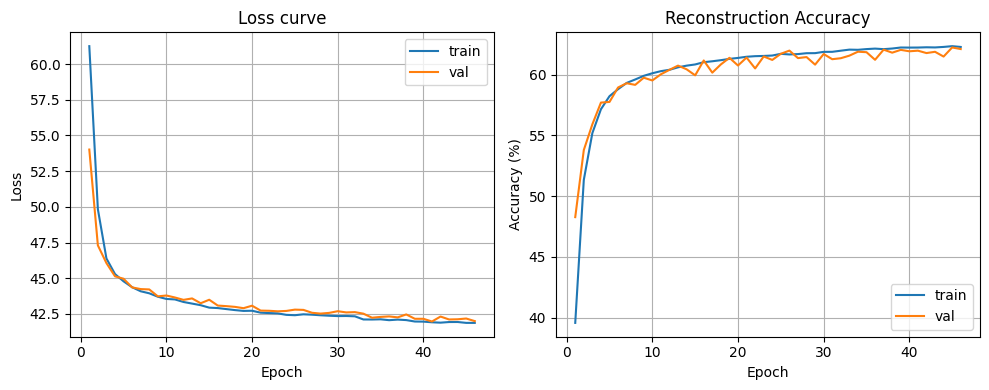

--------------------------------------------------

Dataset: MNIST

β = 0.0


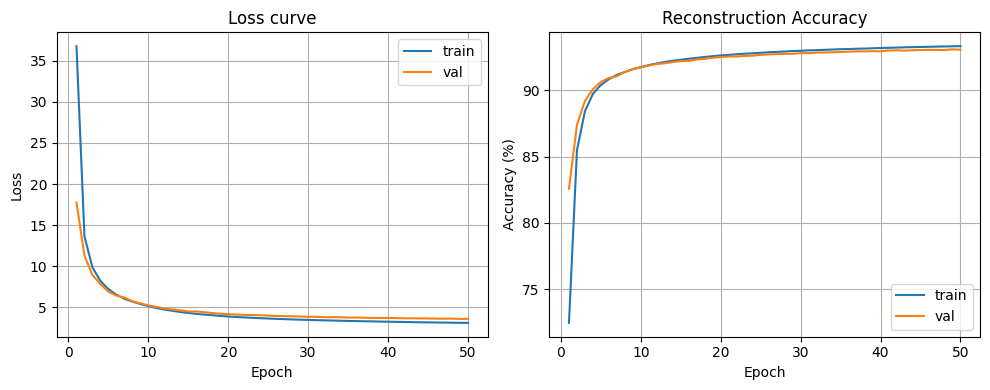

--------------------------------------------------
β = 0.5


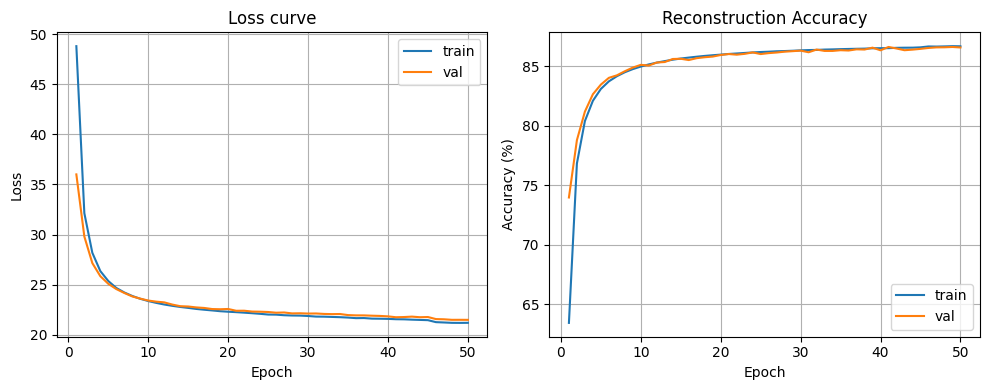

--------------------------------------------------
β = 1.0


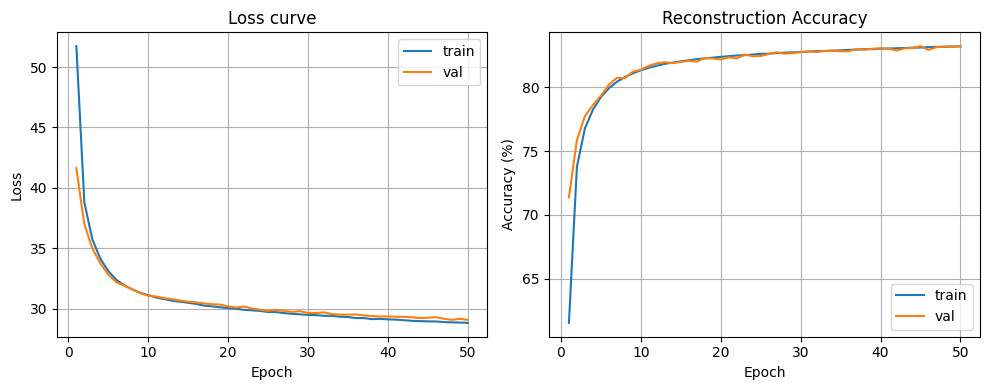

--------------------------------------------------
β = 2.0


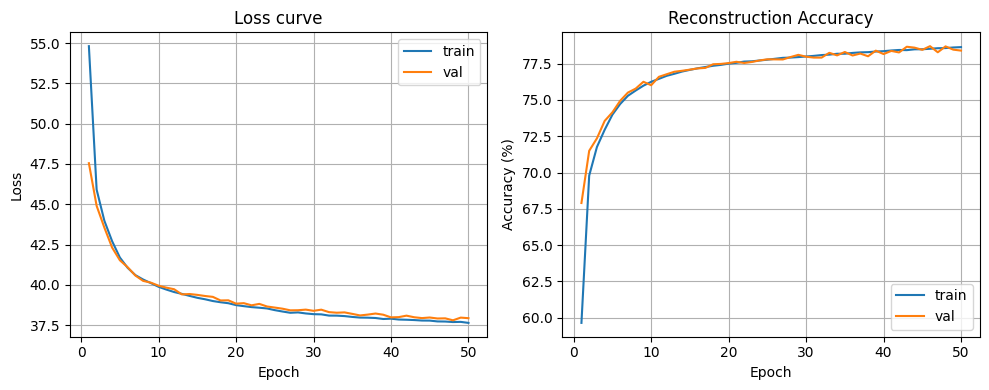

--------------------------------------------------
β = 5.0


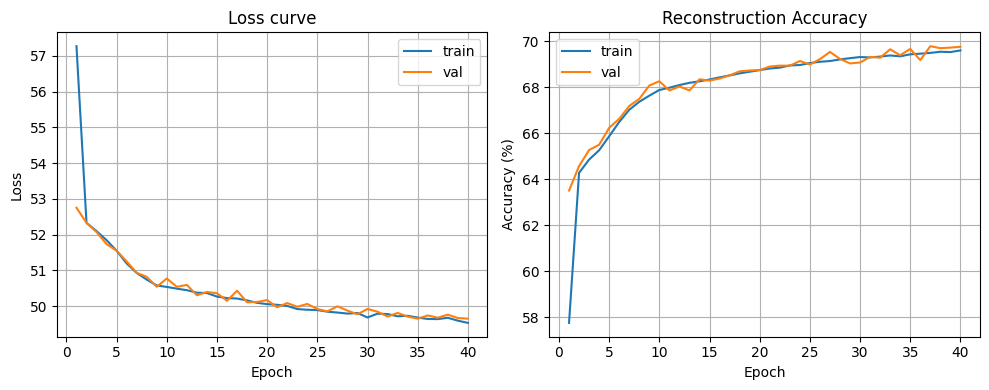

--------------------------------------------------


In [29]:
plot_all_betavae_metrics("Models\\BetaVAE")